In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate, train_test_split, KFold, GridSearchCV
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFECV
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, RegressorMixin

      SEQN age_group  RIDAGEYR  RIAGENDR  PAQ605  BMXBMI  LBXGLU  DIQ010  \
0  73564.0     Adult      61.0       2.0     2.0    35.7   110.0     2.0   
1  73568.0     Adult      26.0       2.0     2.0    20.3    89.0     2.0   
2  73576.0     Adult      16.0       1.0     2.0    23.2    89.0     2.0   
3  73577.0     Adult      32.0       1.0     2.0    28.9   104.0     2.0   
4  73580.0     Adult      38.0       2.0     1.0    35.9   103.0     2.0   
5  73581.0     Adult      50.0       1.0     2.0    23.6   110.0     2.0   
6  73587.0     Adult      14.0       1.0     2.0    38.7    94.0     2.0   
7  73596.0     Adult      57.0       2.0     2.0    38.3   107.0     2.0   
8  73607.0    Senior      75.0       1.0     2.0    38.9    89.0     2.0   
9  73610.0     Adult      43.0       1.0     1.0    28.9    90.0     2.0   

   LBXGLT  LBXIN  
0   150.0  14.91  
1    80.0   3.85  
2    68.0   6.14  
3    84.0  16.15  
4    81.0  10.92  
5   100.0   6.08  
6   202.0  21.11  
7   164.0  

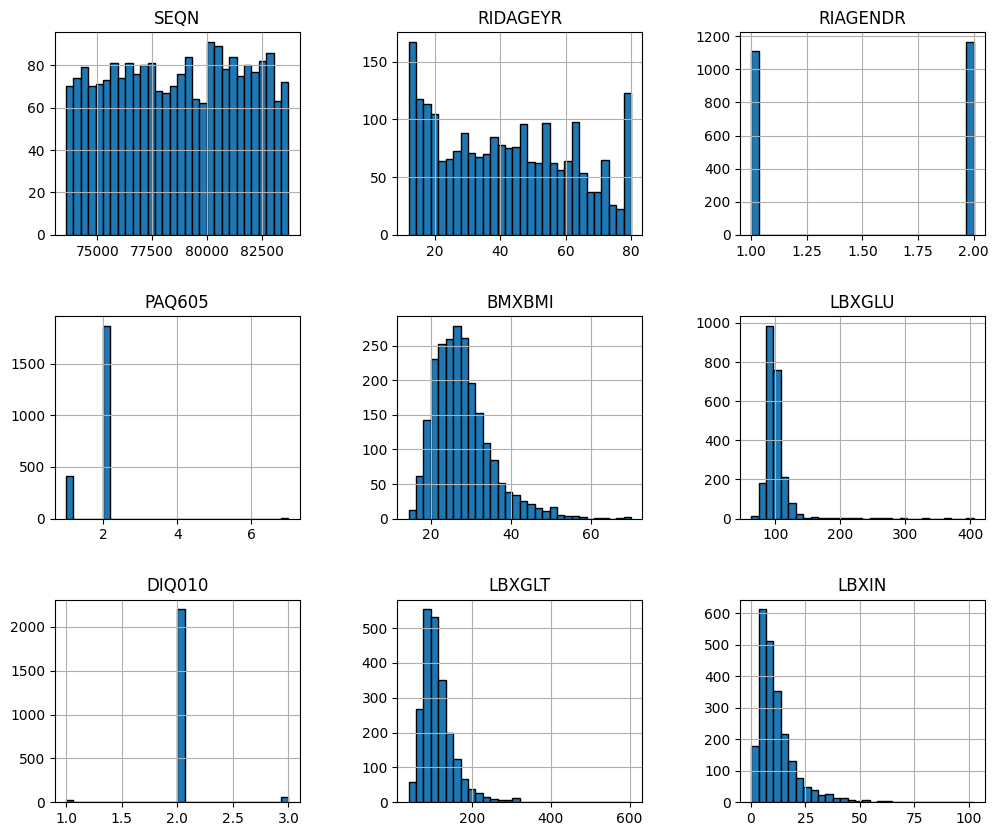

In [ ]:
df = pd.read_csv("NHANES_age_prediction.csv")
print(df.head(10))

df.hist(figsize=(12,10), bins=30, edgecolor="black")
plt.subplots_adjust(hspace=0.4, wspace=0.4)